Import all needed libraries and functions

 For the case of a cylinder perpindicular to the z axis 

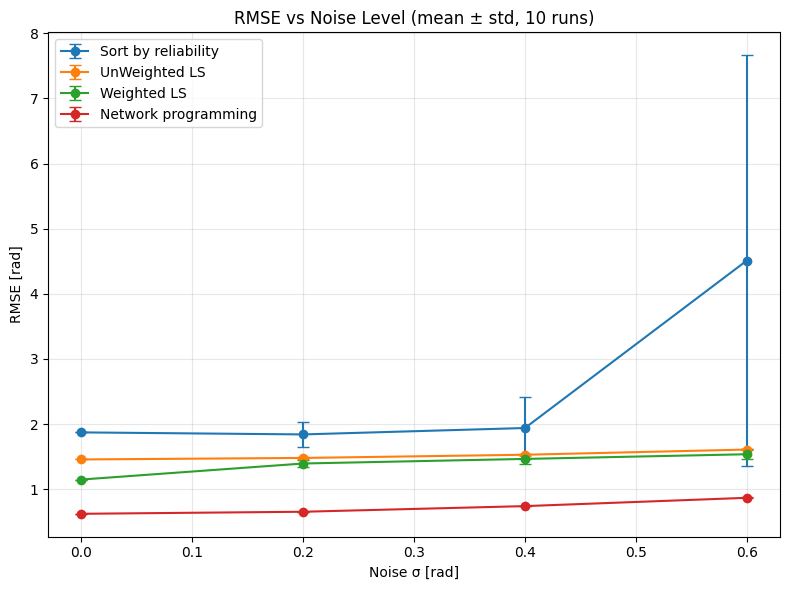

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Noise levels
noise_levels = [0.0, 0.2, 0.4, 0.6]

# Mean ± std data you measured
rmse_means = {
    "Sort by reliability":         [1.8732, 1.8421, 1.9404, 4.5099],
    "UnWeighted LS": [1.4578, 1.4810, 1.5300, 1.6098],
    "Weighted LS":   [1.1494, 1.3956, 1.4659, 1.5377],
    "Network programming":         [0.6236, 0.6551, 0.7415, 0.8689],
}
rmse_stds = {
    "Sort by reliability":         [0.0000, 0.1890, 0.4717, 3.1523],
    "UnWeighted LS": [0.0000, 0.0097, 0.0129, 0.0110],
    "Weighted LS":   [0.0000, 0.0493, 0.0808, 0.0749],
    "Network programming":         [0.0000, 0.0008, 0.0014, 0.0059],
}

methods = list(rmse_means.keys())
colors = ["C0", "C1", "C2", "C3"]

plt.figure(figsize=(8,6))
for m, c in zip(methods, colors):
    plt.errorbar(noise_levels, rmse_means[m], yerr=rmse_stds[m],
                 marker="o", capsize=4, label=m, color=c)

plt.xlabel("Noise σ [rad]")
plt.ylabel("RMSE [rad]")
plt.title("RMSE vs Noise Level (mean ± std, 10 runs)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


SSIM evaluation

In [5]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

# --------------------------------------------------
# Parameters
# --------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]
n_runs = 10
methods = ["SciPy", "UnWeighted LS", "Weighted LS", "Kamui"]

# --------------------------------------------------
# Storage
# --------------------------------------------------
ssim_results = {sigma: {m: [] for m in methods} for sigma in noise_levels}

# --------------------------------------------------
# Main loop
# --------------------------------------------------
for sigma in noise_levels:
    for run in range(n_runs):
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)

        # Precompute weights (for Weighted LS)
        weights = reliability_weight_map(phi_noisy)
        weights_masked = weights * tissue_mask

        # Run all methods
        phi_scipy   = unwrap_phase(phi_noisy)
        phi_ls      = unwrap_phase_weighted(phi_noisy)
        phi_weight  = unwrap_phase_weighted(phi_noisy, weights_masked)
        phi_kamui   = unwrap_dimensional(phi_noisy)

        # Evaluate SSIM against ground truth
        ssim_results[sigma]["SciPy"].append(
            ssim(phi_true, phi_scipy, data_range=phi_true.max() - phi_true.min())
        )
        ssim_results[sigma]["UnWeighted LS"].append(
            ssim(phi_true, phi_ls, data_range=phi_true.max() - phi_true.min())
        )
        ssim_results[sigma]["Weighted LS"].append(
            ssim(phi_true, phi_weight, data_range=phi_true.max() - phi_true.min())
        )
        ssim_results[sigma]["Kamui"].append(
            ssim(phi_true, phi_kamui, data_range=phi_true.max() - phi_true.min())
        )

# --------------------------------------------------
# Report
# --------------------------------------------------
print("Mean SSIM per method (5 runs each):")
for sigma in noise_levels:
    print(f"\nNoise σ = {sigma}")
    for m in methods:
        vals = ssim_results[sigma][m]
        print(f"  {m:15s}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")


Mean SSIM per method (5 runs each):

Noise σ = 0.0
  SciPy          : 0.7144 ± 0.0000
  UnWeighted LS  : 0.1479 ± 0.0000
  Weighted LS    : 0.1255 ± 0.0000
  Kamui          : 0.8418 ± 0.0000

Noise σ = 0.2
  SciPy          : 0.6728 ± 0.0433
  UnWeighted LS  : 0.1493 ± 0.0005
  Weighted LS    : 0.1501 ± 0.0005
  Kamui          : 0.7773 ± 0.0005

Noise σ = 0.4
  SciPy          : 0.2259 ± 0.2593
  UnWeighted LS  : 0.1291 ± 0.0007
  Weighted LS    : 0.1316 ± 0.0003
  Kamui          : 0.6408 ± 0.0164

Noise σ = 0.6
  SciPy          : 0.1889 ± 0.1647
  UnWeighted LS  : 0.1020 ± 0.0006
  Weighted LS    : 0.1057 ± 0.0003
  Kamui          : 0.5439 ± 0.0005


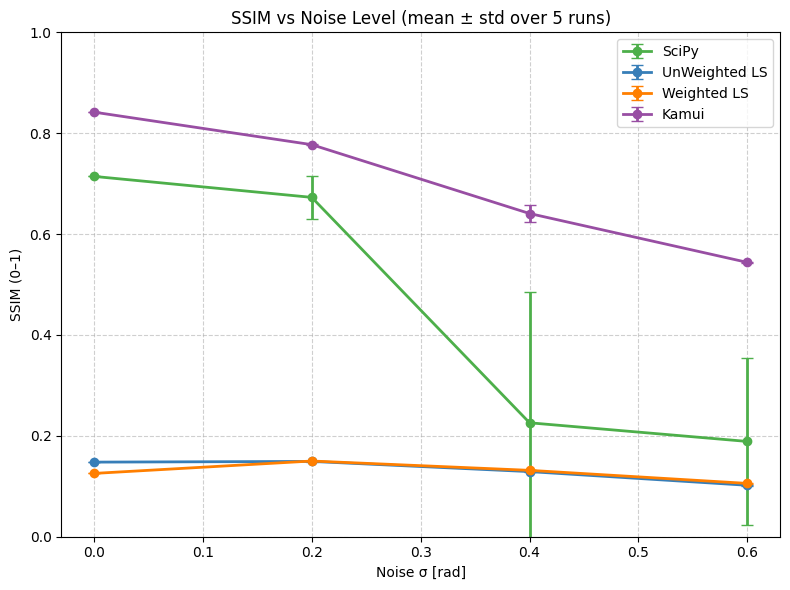

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data: mean ± std
noise_levels = [0.0, 0.2, 0.4, 0.6]

ssim_data = {
    "SciPy": {
        "mean": [0.7144, 0.6728, 0.2259, 0.1889],
        "std":  [0.0000, 0.0433, 0.2593, 0.1647],
    },
    "UnWeighted LS": {
        "mean": [0.1479, 0.1493, 0.1291, 0.1020],
        "std":  [0.0000, 0.0005, 0.0007, 0.0006],
    },
    "Weighted LS": {
        "mean": [0.1255, 0.1501, 0.1316, 0.1057],
        "std":  [0.0000, 0.0005, 0.0003, 0.0003],
    },
    "Kamui": {
        "mean": [0.8418, 0.7773, 0.6408, 0.5439],
        "std":  [0.0000, 0.0005, 0.0164, 0.0005],
    }
}

# Plot
plt.figure(figsize=(8,6))

colors = {
    "SciPy": "#4daf4a",
    "UnWeighted LS": "#377eb8",
    "Weighted LS": "#ff7f00",
    "Kamui": "#984ea3",
}

for method, vals in ssim_data.items():
    means = vals["mean"]
    stds = vals["std"]
    plt.errorbar(noise_levels, means, yerr=stds, label=method,
                 marker='o', capsize=4, linewidth=2, color=colors[method])

plt.ylim(0,1)
plt.xlabel("Noise σ [rad]")
plt.ylabel("SSIM (0–1)")
plt.title("SSIM vs Noise Level (mean ± std over 5 runs)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
from skimage.restoration import unwrap_phase
from src.Ghilia.Ghilia import unwrap_phase_weighted
from src.Ghilia.reliability import reliability_weight_map
from kamui import unwrap_dimensional
import ssim.ssimlib as pyssim
from PIL import Image

# --------------------------------------------------
# Helper: convert float array to PIL grayscale image
# --------------------------------------------------
def to_pil_gray(im):
    im_norm = (im - im.min()) / (im.max() - im.min() + 1e-8)
    im_uint8 = (im_norm * 255).astype(np.uint8)
    return Image.fromarray(im_uint8, mode="L")

# --------------------------------------------------
# Parameters
# --------------------------------------------------
noise_levels = [0.0, 0.2, 0.4, 0.6]
n_runs = 10
methods = ["SciPy", "UnWeighted LS", "Weighted LS", "Kamui"]

# --------------------------------------------------
# Storage
# --------------------------------------------------
cwssim_results = {sigma: {m: [] for m in methods} for sigma in noise_levels}

# --------------------------------------------------
# Main loop
# --------------------------------------------------
for sigma in noise_levels:
    for run in range(n_runs):
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)

        # Precompute weights (for Weighted LS)
        weights = reliability_weight_map(phi_noisy)
        weights_masked = weights * tissue_mask

        # Run all methods
        phi_scipy   = unwrap_phase(phi_noisy)
        phi_ls      = unwrap_phase_weighted(phi_noisy)
        phi_weight  = unwrap_phase_weighted(phi_noisy, weights_masked)
        phi_kamui   = unwrap_dimensional(phi_noisy)

        # Evaluate CW-SSIM (convert to PIL first)
        img_true = to_pil_gray(phi_true)

        cwssim_results[sigma]["SciPy"].append(
            pyssim.SSIM(img_true).cw_ssim_value(to_pil_gray(phi_scipy))
        )
        cwssim_results[sigma]["UnWeighted LS"].append(
            pyssim.SSIM(img_true).cw_ssim_value(to_pil_gray(phi_ls))
        )
        cwssim_results[sigma]["Weighted LS"].append(
            pyssim.SSIM(img_true).cw_ssim_value(to_pil_gray(phi_weight))
        )
        cwssim_results[sigma]["Kamui"].append(
            pyssim.SSIM(img_true).cw_ssim_value(to_pil_gray(phi_kamui))
        )

# --------------------------------------------------
# Report
# --------------------------------------------------
print("Mean CW-SSIM per method (10 runs each):")
for sigma in noise_levels:
    print(f"\nNoise σ = {sigma}")
    for m in methods:
        vals = cwssim_results[sigma][m]
        print(f"  {m:15s}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")


C:\Users\ofirh\AppData\Local\Temp\ipykernel_27092\2955845955.py:15: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(im_uint8, mode="L")


Mean CW-SSIM per method (10 runs each):

Noise σ = 0.0
  SciPy          : 0.8641 ± 0.0000
  UnWeighted LS  : 0.4141 ± 0.0000
  Weighted LS    : 0.4037 ± 0.0000
  Kamui          : 0.5959 ± 0.0000

Noise σ = 0.2
  SciPy          : 0.3827 ± 0.0358
  UnWeighted LS  : 0.4359 ± 0.0021
  Weighted LS    : 0.4318 ± 0.0009
  Kamui          : 0.4385 ± 0.0005

Noise σ = 0.4
  SciPy          : 0.3644 ± 0.0189
  UnWeighted LS  : 0.4373 ± 0.0017
  Weighted LS    : 0.4363 ± 0.0019
  Kamui          : 0.4217 ± 0.0007

Noise σ = 0.6
  SciPy          : 0.3376 ± 0.0290
  UnWeighted LS  : 0.4296 ± 0.0027
  Weighted LS    : 0.4324 ± 0.0020
  Kamui          : 0.4075 ± 0.0034


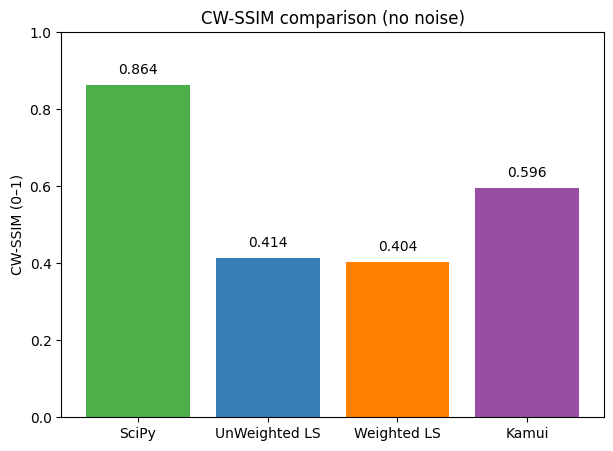

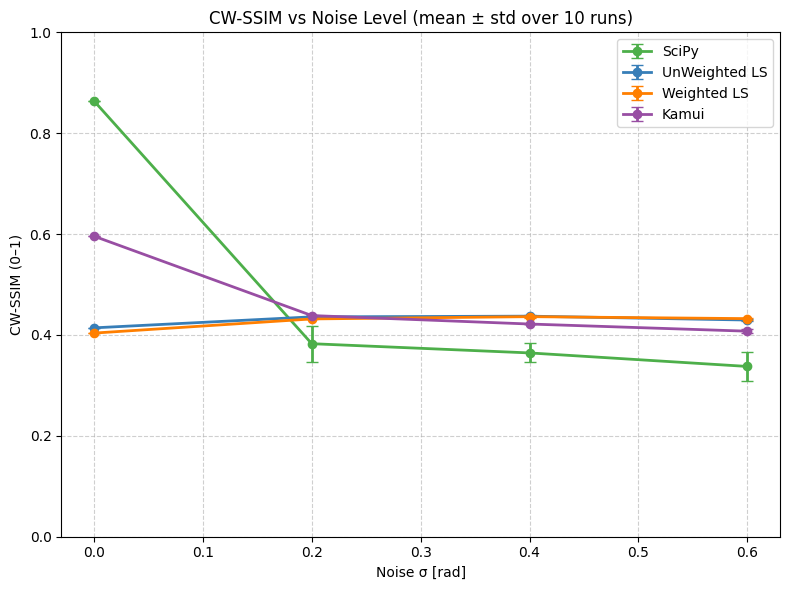

In [15]:
import matplotlib.pyplot as plt

# Your CW-SSIM results (no noise)
cwssim_scores = {
    "SciPy": 0.8641,
    "UnWeighted LS": 0.4141,
    "Weighted LS": 0.4037,
    "Kamui": 0.5959,
}

# Plot
methods = list(cwssim_scores.keys())
scores = list(cwssim_scores.values())

plt.figure(figsize=(7,5))
bars = plt.bar(methods, scores, color=["#4daf4a","#377eb8","#ff7f00","#984ea3"])
plt.ylim(0,1)
plt.ylabel("CW-SSIM (0–1)")
plt.title("CW-SSIM comparison (no noise)")

# Annotate values on top of bars
for bar, val in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.02,
             f"{val:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()
import matplotlib.pyplot as plt

# Data
noise_levels = [0.0, 0.2, 0.4, 0.6]

cwssim_data = {
    "SciPy": {
        "mean": [0.8641, 0.3827, 0.3644, 0.3376],
        "std":  [0.0000, 0.0358, 0.0189, 0.0290],
    },
    "UnWeighted LS": {
        "mean": [0.4141, 0.4359, 0.4373, 0.4296],
        "std":  [0.0000, 0.0021, 0.0017, 0.0027],
    },
    "Weighted LS": {
        "mean": [0.4037, 0.4318, 0.4363, 0.4324],
        "std":  [0.0000, 0.0009, 0.0019, 0.0020],
    },
    "Kamui": {
        "mean": [0.5959, 0.4385, 0.4217, 0.4075],
        "std":  [0.0000, 0.0005, 0.0007, 0.0034],
    }
}

# Colors for consistency
colors = {
    "SciPy": "#4daf4a",
    "UnWeighted LS": "#377eb8",
    "Weighted LS": "#ff7f00",
    "Kamui": "#984ea3",
}

# Plot
plt.figure(figsize=(8,6))

for method, vals in cwssim_data.items():
    plt.errorbar(
        noise_levels, vals["mean"], yerr=vals["std"],
        label=method, marker="o", capsize=4, linewidth=2,
        color=colors[method]
    )

plt.ylim(0, 1)
plt.xlabel("Noise σ [rad]")
plt.ylabel("CW-SSIM (0–1)")
plt.title("CW-SSIM vs Noise Level (mean ± std over 10 runs)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
